# Example for Gaussian Process Regression (GPR)

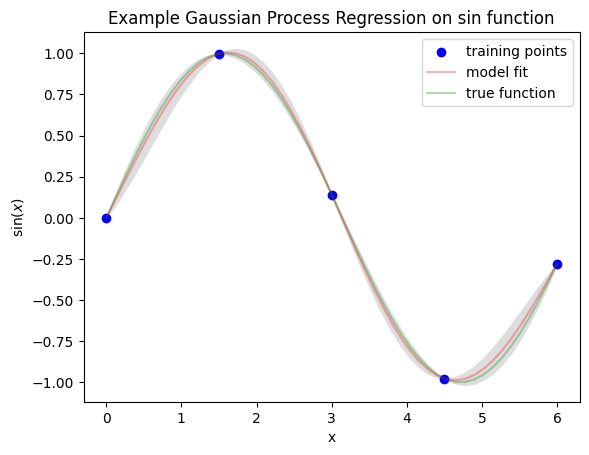

In [9]:
import numpy as np
from matplotlib import pyplot as plt
from ichor.core.models.kernels.distance import Distance

# example Gaussian process regression notebook on sin function
# References:
# 1. Williams, C. K., & Rasmussen, C. E. (2006). Gaussian processes for machine learning
# (Vol. 2, No. 3, p. 4). Cambridge, MA: MIT press.
# 2. Gramacy, Robert B. Surrogates: Gaussian process modeling, design, and optimization for the applied sciences.
#  Chapman and Hall/CRC, 2020
# 3. https://distill.pub/2019/visual-exploration-gaussian-processes/

def rbf_kernel(a, b, sigma,l):
    """Definition of RBF kernel with lengthscale and variance.
    
    :param a: A 1D array containing the values for x
    :param b: A 1D array containing the values for x'
    :return: The covariance matrix calculated with the RBF kernel,
        with covariance between each pair of values in x and x'
        calculated.
    """
    dist2 = Distance.squared_euclidean_distance(a, b)

    return sigma**2*np.exp(-dist2/(2*l**2))

# training inputs
train_x = np.linspace(0, 6, 5).reshape(-1,1)
# training outputs
train_y = np.sin(train_x)
# test inputs
test_x = np.linspace(0, 6, 50).reshape(-1,1)
# true test outputs, these will be used to check how good model predictions are
test_x_true = np.sin(test_x)

ntrain = train_x.shape[0] # number of training points

mu = 0.0 # prior GP mean
LENGTHSCALE = 2.0 # lengthscale hyperparameter for the single input dimension
OUTPUTSCALE = 1.0 # outputscale hyperparameter
NOISE = 1e-12 * np.eye(ntrain) # noise to be added to the diagonal of covariance matrix

# n_train x n_train with noise on diagonal
K = rbf_kernel(train_x, train_x, OUTPUTSCALE, LENGTHSCALE) + NOISE
# ntest x n_train
K_s = rbf_kernel(test_x, train_x, OUTPUTSCALE, LENGTHSCALE)
# n_test x n_test
K_ss = rbf_kernel(test_x, test_x, OUTPUTSCALE, LENGTHSCALE)

# Cholesky decomposition used on K (train train matrix)
# because it is square symmetric positive semidefinite
L = np.linalg.cholesky(K)
alpha = np.linalg.solve(L.T, np.linalg.solve(L, train_y)) # weights
v = np.linalg.solve(L, K_s.T) # temp vector to calculate variance

# obtain model predictions of function value and variance at test locations
# see Section 2.3 (Varying the Hyperparameters), Algorithm 2.1 of Rasmussen and Williams (p. 19)
predictions = (mu + np.matmul(K_s, alpha)).flatten()
posterior_covariance = K_ss - np.dot(v.T, v)
var = np.diag(posterior_covariance)
stdv = np.sqrt(var)

errors = test_x_true.flatten() - predictions

# 2 sigma confidence interval
# this represents the model uncertainty
plt.gca().fill_between(test_x.flatten(), predictions-2*stdv, predictions+2*stdv, color="#dddddd")
# plot training data as points
plt.scatter(train_x, train_y, color="b", label="training points")
# plot test points as a line
plt.plot(test_x, predictions, color="r", label="model fit", alpha=0.3)
plt.plot(test_x, test_x_true, color="g", label="true function", alpha=0.3)
plt.title("Example Gaussian Process Regression on sin function")
plt.xlabel("$x$")
plt.ylabel("$\sin(x)$")
plt.legend()
plt.show()